In [3]:
DATA_DIR = "G:\dataset\ml-100k"

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = pd.read_csv(os.path.join(DATA_DIR, 'u.data'),
                   names=['user', 'item', 'rating', 'timestamp'],
                   sep='\t')

In [6]:
data.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
table = data.pivot_table(values='rating', index='user', columns='item')
table.head()

item,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print(os.listdir(DATA_DIR))

['allbut.pl', 'mku.sh', 'README', 'u.data', 'u.genre', 'u.info', 'u.item', 'u.occupation', 'u.user', 'u1.base', 'u1.test', 'u2.base', 'u2.test', 'u3.base', 'u3.test', 'u4.base', 'u4.test', 'u5.base', 'u5.test', 'ua.base', 'ua.test', 'ub.base', 'ub.test']


In [9]:
open(os.path.join(DATA_DIR, 'u.item')).readline()

'1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0\n'

# Loading movie ratings dataset

In [10]:
#https://raw.githubusercontent.com/luispedro/BuildingMachineLearningSystemsWithPython/master/ch08/load_ml100k.py
def load(fpath):
    '''Load ML-100k data
    Returns the review matrix as a numpy array'''
    import numpy as np
    from scipy import sparse
    from os import path

    if not path.exists(fpath):
        raise IOError("Data has not been downloaded.\nTry the following:\n\n\tcd data\n\t./download.sh")

    # The input is in the form of a CSC sparse matrix, so it's a natural fit to
    # load the data, but we then convert to a more traditional array before
    # returning
    data = np.loadtxt(fpath)
    ij = data[:, :2]
    ij -= 1  # original data is in 1-based system
    values = data[:, 2]
    reviews = sparse.csc_matrix((values, ij.T)).astype(float)
    return reviews.toarray()

In [11]:
Y = load(os.path.join(DATA_DIR, 'u.data'))
Y = Y.T
print(Y.shape)
print(Y)

(1682, 943)
[[5. 4. 0. ... 5. 0. 0.]
 [3. 0. 0. ... 0. 0. 5.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
R = (Y>0).astype(np.uint)

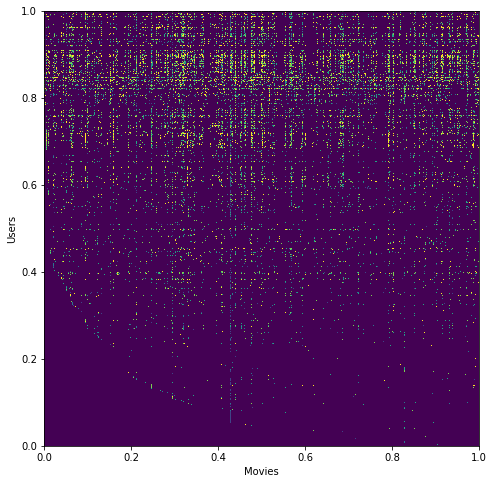

In [13]:
# Visualize the ratings matrix
plt.figure(figsize=(8,8))
plt.imshow(Y,  extent=[0, 1, 0, 1])
plt.xlabel('Movies')
plt.ylabel('Users')

# Collaborative filtering cost function

In [14]:
# Load .mat file of matlab
# https://stackoverflow.com/questions/874461/read-mat-files-in-python
import scipy.io as sio
mat = sio.loadmat('./ex8_movieParams.mat')

In [15]:
Theta = mat['Theta']
X = mat['X']

In [16]:
# Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [17]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lamb):
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    J = 0
    X_grad = np.zeros_like(X)
    Theta_grad = np.zeros_like(Theta)
    
    J = np.sum((X.dot(Theta.T) - Y)**2 * R) / 2 \
        + np.sum(Theta**2) * lamb / 2 \
        + np.sum(X**2) * lamb / 2
    return J

In [18]:
params = np.concatenate((X.ravel(), Theta.ravel()))
J = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 0)
print('Cost at loaded parameters: %f\nThis value should be about 22.22' % J)

Cost at loaded parameters: 22.224604
This value should be about 22.22


# Collaborative Filtering Gradient

## CF的计算目标
同时最小化$x^{(1)},\ldots,x^{(n_m)}$和$\theta^{(1)},\ldots,\theta^{(n_u)}$:
$$ J(x^{(1)},\ldots,x^{(n_m)},\theta^{(1)},\ldots,\theta^{(n_u)}) = 
    \frac{1}{2}\sum_{(i,j):r(i,j)=1}((\theta^{(j)})^Tx^{(i)} - y^{(i,j)})^2
    + \frac{\lambda}{2}\sum^{n_m}_{i=1}\sum^{n}_{k=1}(x_k^{(i)})^2 + \frac{\lambda}{2}\sum^{n_u}_{i=1}\sum^{n}_{k=1}(\theta_k^{(j)})^2
$$
即：
$$ \min_{x^{(1)},\ldots,x^{(n_m)},\theta^{(1)},\ldots,\theta^{(n_u)}} J(x^{(1)},\ldots,x^{(n_m)},\theta^{(1)},\ldots,\theta^{(n_u)}) $$

## Collaborative filtering algorithm
1. Initialize $x^{(1)},\ldots,x^{(n_m)}, \theta^{(1)},\ldots,\theta^{(n_u)}$ to small random values:
2. Minimize $J(x^{(1)},\ldots,x^{(n_m)}, \theta^{(1)},\ldots,\theta^{(n_u)})$ using gradient descent(or an advanced optimization algorithm). E.g. for every $j=1,\ldots,n_u, i=1,\ldots,n_m$:

$$ x_k^{(i)} := x_k^{(i)} - \alpha(\sum_{j:r(i,j)=1)}((\theta^{(j)})^Tx^{(i)} - y^{(i,j)})\theta_k^{(j)} + \lambda x_k^{(i)})
$$
$$ \theta_k^{(j)} := \theta_k^{(j)} - \alpha(\sum_{i:r(i,j)=1)}((\theta^{(j)})^Tx^{(i)} - y^{(i,j)})\theta_k^{(i)} + \lambda \theta_k^{(j)})
$$

3. For a user with parameters $\theta$ and a movie with(learned) features $x$, predict a star rating of $\theta^Tx$.

In [19]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lamb):
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    J = 0
    X_grad = np.zeros_like(X)
    Theta_grad = np.zeros_like(Theta)
    
    J = np.sum((X.dot(Theta.T) - Y)**2 * R) / 2 \
        + np.sum(Theta**2) * lamb / 2 \
        + np.sum(X**2) * lamb / 2
        
    X_grad = ((X.dot(Theta.T) - Y) * R).dot(Theta) + lamb * X
    Theta_grad = ((X.dot(Theta.T) - Y) * R).T.dot(X) + lamb * Theta
    return J, X_grad, Theta_grad

In [20]:
# Check gradient

In [21]:
J, X_grad, Theta_grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 0)
print("X_grad:")
print(X_grad)
print('\n')
print("Theta_grad")
print(Theta_grad)

X_grad:
[[-2.52899165  7.57570308 -1.89979026]
 [-0.56819597  3.35265031 -0.52339845]
 [-0.83240713  4.91163297 -0.76677878]
 [-0.38358278  2.26333698 -0.35334048]
 [-0.80378006  4.74271842 -0.74040871]]


Theta_grad
[[-10.5680202    4.62776019  -7.16004443]
 [ -3.05099006   1.16441367  -3.47410789]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]


In [22]:
# Evaluate cost function with regularization
J, X_grad, Theta_grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 1.5)
print('Cost at loaded parameters(lambda = 1.5: %f\nThis value should be about 31.34' % J)

Cost at loaded parameters(lambda = 1.5: 31.344056
This value should be about 31.34


# Entering ratings for a new user

In [23]:
movieList = pd.read_csv("Movie_Id_Titles")
movieList = list(movieList['title'])
movieList[:5]

['Toy Story (1995)',
 'GoldenEye (1995)',
 'Four Rooms (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)']

In [24]:
my_ratings = np.zeros([1682, 1])

In [30]:
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3;
my_ratings[11]= 5;
my_ratings[53] = 4;
my_ratings[63]= 5;
my_ratings[65]= 3;
my_ratings[68] = 5;
my_ratings[182] = 4;
my_ratings[225] = 5;
my_ratings[354]= 5;

print("New user ratings: ")
for i in range(len(my_ratings)):
    if my_ratings[i]:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))

New user ratings: 
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)


# Learning Movie Ratings

In [31]:
Y = load(os.path.join(DATA_DIR, 'u.data'))
Y = Y.T
R = (Y>0).astype(np.uint)

In [32]:
# Add your own ratings to the data matrix
Y = np.hstack((my_ratings, Y))
R = np.hstack(((my_ratings!=0), R))
print(Y.shape, R.shape)
print(Y)

(1682, 944) (1682, 944)
[[4. 5. 4. ... 5. 0. 0.]
 [0. 3. 0. ... 0. 0. 5.]
 [0. 4. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [33]:
# Normalize Ratings
def normalizeRatings(Y, R):
    m, n = Y.shape
    Ymean = np.zeros((m, 1))
    Ynorm = np.zeros((m, n))
    for i in range(len(Y)):
        idx = np.where(R[i, :] == 1)
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]
    return Ynorm, Ymean

In [34]:
Ynorm, Ymean = normalizeRatings(Y, R)

In [35]:
# Useful values
num_movies, num_users = Y.shape
num_features = 10

# Set initial parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_params = np.concatenate((X.ravel(), Theta.ravel()), axis=0)

# Trainin hyperparameters
MaxIter = 100
lamb = 10

In [50]:
def f(params, *args):
    Ynorm, R, num_users, num_movies, num_features, lamb = args
    J, X_grad, Theta_grad = cofiCostFunc(params, Ynorm, R, num_users, num_movies, num_features, lamb)
    return J

def gradf(params, *args):
    Ynorm, R, num_users, num_movies, num_features, lamb = args
    J, X_grad, Theta_grad = cofiCostFunc(params, Ynorm, R, num_users, num_movies, num_features, lamb)
    return np.concatenate((X_grad.ravel(), Theta_grad.ravel()))

In [51]:
J = f(initial_params, Ynorm, R, num_users, num_movies, num_features, lamb)
print(J)
grad = gradf(initial_params, Ynorm, R, num_users, num_movies, num_features, lamb)
print(grad.shape)

658487.0472685507
(26260,)


In [52]:
initial_params.shape

(26260,)

In [55]:
# http://www.noneface.com/2016/08/07/Scipy-optimize-minimize.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cg.html
# res = optimize.minimize(computeCost, initial_theta, args=(X, y), method = 'BFGS', jac=gradient, options={'maxiter':50})
from scipy import optimize
res = optimize.minimize(f, initial_params, args=(Ynorm, R, num_users, num_movies, num_features, lamb),
                        method='CG', jac=gradf,
                        options={'maxiter':100, 'disp': True})

         Current function value: 38965.472977
         Iterations: 100
         Function evaluations: 152
         Gradient evaluations: 152


In [60]:
res

     fun: 38965.47297673023
     jac: array([ 0.28872493, -0.05981527,  0.31753384, ...,  0.014092  ,
        0.02006138,  0.01593668])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 152
     nit: 100
    njev: 152
  status: 1
 success: False
       x: array([-0.56225165,  0.00912126, -0.43896685, ..., -0.01745587,
       -0.19148427,  0.41201241])

In [65]:
X = res.x[:num_movies*num_features].reshape(num_movies, num_features)
Theta = res.x[num_movies*num_features:].reshape(num_users, num_features)
print("Recommender system learning completed.")

Recommender system learning completed.


# Recommendation for you
After training the model, you can now make recommendations by computing the predictions matrix.

In [87]:
p = X.dot(Theta.T)
my_predictions = p[:, 0] + Ymean.ravel()

In [88]:
sorted(enumerate(my_predictions), key=lambda x:x[1], reverse=True)

[(813, 5.000007709317205),
 (1598, 5.0000000087852206),
 (1292, 5.000000003606576),
 (1200, 5.000000003575101),
 (1188, 5.000000002258905),
 (1466, 4.999999998577232),
 (1652, 4.999999997613772),
 (1121, 4.9999999877930215),
 (1535, 4.999999981352112),
 (1499, 4.999999224512989),
 (1448, 4.641772509623862),
 (49, 4.633382893821953),
 (63, 4.562220940008386),
 (118, 4.518616247461477),
 (168, 4.507106145301418),
 (1397, 4.50617532138426),
 (1641, 4.495088864136194),
 (317, 4.491824020108008),
 (1593, 4.490620586252104),
 (173, 4.477593230453193),
 (407, 4.458495083901727),
 (171, 4.443383308714883),
 (482, 4.439672928404659),
 (11, 4.437107144464553),
 (113, 4.417549009252148),
 (312, 4.3844468866583055),
 (180, 4.375299318195231),
 (512, 4.3711908170742815),
 (962, 4.366239885299942),
 (133, 4.346790927855964),
 (1190, 4.335577883176893),
 (315, 4.334690957769267),
 (21, 4.3323272676307605),
 (1638, 4.332042166024761),
 (602, 4.316706079533376),
 (284, 4.315023563256232),
 (126, 4.2970

In [96]:
r = [i[0] for i in sorted(enumerate(my_predictions), key=lambda x:x[1], reverse=True)]

In [99]:
print("Top recommendation for you: ")
for i in r[:10]:
    movieName = movieList[i]
    print("Predicting rating %.1f for movie %s" % (my_predictions[i], movieName))

Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996) 
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Santa with Muscles (1996)


In [101]:
print("Original ratings provided: ")
for i in range(len(my_ratings)):
    if my_ratings[i]:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))

Original ratings provided: 
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)
